In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import sys
from tqdm import tqdm
import utils, models
import torch.nn.functional as F
import math
import random
import gpytorch

/home/toni/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def install_package(package):
    import sys
    !{sys.executable} -m pip install package

In [3]:
training_set = pd.read_csv("Data/training_set.csv")
training_set_metadata = pd.read_csv("Data/training_set_metadata.csv")

print(training_set.shape, training_set_metadata.shape)

(1421705, 6) (7848, 12)


In [4]:
data_obj, label = utils.load_passbands_list(path = "Data/Data_as_h5/obj_passbands.h5", objid = 615, path_enter = "Data/")

In [5]:
N = 1000

times_obj = torch.cat( [ obj[:,0:1] for obj in data_obj ], dim = 0 )
times_obj = (times_obj.flatten())[ torch.argsort( times_obj.flatten() ) ].view(-1,1)

min_time, max_time = torch.min(times_obj), torch.max(times_obj)

times_obj_extra = torch.linspace(min_time, max_time, N).view(-1,1)

new_time = torch.cat( (times_obj, times_obj_extra), dim = 0 )
new_time = (new_time.flatten())[ torch.argsort( new_time.flatten() ) ].view(-1,1)

In [44]:
# Specify the passband
passband = 0

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = models.ExactGPModel(train_x = data_obj[passband][:,0:1].flatten(), train_y = data_obj[passband][:,1:2].flatten(), likelihood = likelihood)

In [45]:
observed_pred = utils.train_GP_and_eval(model = model, data_obj = data_obj, passband = passband, new_time = new_time, likelihood = likelihood, num_iterations = 100)

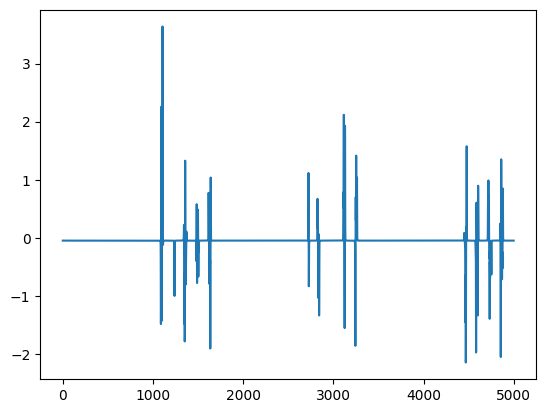

In [46]:
plt.plot(observed_pred)
plt.show()

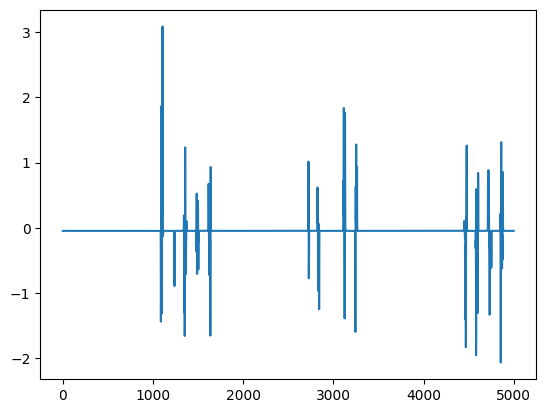

In [42]:
plt.plot(observed_pred)
plt.show()

In [10]:
# First, extract minimum and maximum times from all the entire data

training_set = pd.read_csv("Data/training_set.csv")
training_set_metadata = pd.read_csv("Data/training_set_metadata.csv")

print(training_set.shape, training_set_metadata.shape)

obj_ids = training_set_metadata["object_id"].values.tolist()

min_times, max_times = [], []

for i in tqdm(range( len(obj_ids) ) ):
    data_obj, label = utils.load_passbands_list(path = "Data/Data_as_h5/obj_passbands.h5", objid = obj_ids[i], path_enter = "Data/")
    min_times.append( float( torch.min( torch.cat( [ obj[:,0:1] for obj in data_obj ], dim = 0 ).flatten() ) ) )
    max_times.append( float( torch.max( torch.cat( [ obj[:,0:1] for obj in data_obj ], dim = 0 ).flatten() ) ) )

general_min, general_max = np.min(min_times), np.max(max_times)

print("Total minimum time: ", general_min)
print("Total maximum time: ", general_max)

(1421705, 6) (7848, 12)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7848/7848 [01:49<00:00, 71.52it/s]

Total minimum time:  59580.03515625
Total maximum time:  60674.36328125


In [14]:
new_time = torch.linspace( general_min, general_max, 5000 )

In [37]:
all_tensors, all_labels = [], []
#for i in tqdm( range( len(obj_ids) ) ):
for i in tqdm( range( 3 ) ):
    # Specify an object
    data_obj, label = utils.load_passbands_list(path = "Data/Data_as_h5/obj_passbands.h5", objid = obj_ids[i], path_enter = "Data/")
    all_labels.append( label )
    # Now, go through all the passbands and adjust the models
    pred_passbands = []
    for j in range(0, 6):
        # Initialize likelihood and model
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        model = models.ExactGPModel(train_x = data_obj[j][:,0:1].flatten(), train_y = data_obj[j][:,1:2].flatten(), likelihood = likelihood)
        
        observed_pred = utils.train_GP_and_eval(model = model, data_obj = data_obj, passband = j, new_time = new_time, likelihood = likelihood, num_iterations = 1000)
        pred_passbands.append( observed_pred )
    pred_passbands = torch.stack( pred_passbands, dim = 1 ).unsqueeze(0)
    all_tensors.append( pred_passbands )
all_tensors = torch.cat(all_tensors, dim = 0)
all_labels = torch.tensor(all_labels).view(-1,1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:41<00:00, 33.98s/it]


In [35]:
all_tensors.shape

torch.Size([3, 5000, 6])

In [38]:
all_labels.shape

torch.Size([3, 1])

In [43]:
sys.getsizeof(all_tensors)

72